In [32]:
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.datasets
from statistics import mean

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)      
torch.cuda.manual_seed(0) 
torch.backends.cudnn.deterministic = True  

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [5]:
X_train = MNIST_train.data
X_test = MNIST_test.data
y_train = MNIST_train.targets
y_test = MNIST_test.targets

In [6]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [7]:
X_train = X_train.float()
X_test = X_test.float()

In [8]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [9]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

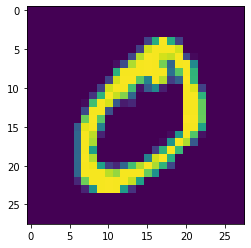

In [10]:
plt.imshow(X_train[1, :, :])
plt.show()

In [11]:
y_train[1]

tensor(0)

In [12]:
X_train = X_train.reshape(-1, 28*28) 
X_test = X_test.reshape(-1, 28*28)

In [13]:
class MNISTNet(torch.nn.Module):  
    def __init__(self, n_neurons):  
        super(MNISTNet, self).__init__() 
        self.fc1 = torch.nn.Linear(784, n_neurons) 
        self.act1 = torch.nn.Sigmoid() 
        self.fc2 = torch.nn.Linear(n_neurons, 10)  
        
    def forward(self, x): 
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x 

In [29]:
def train_model(net, loss, optimizer, n_epoch=100, batch_size=100):
    test_accuracy_history = []
    train_loss_history = []
    test_loss_history = []
    for epoch in range(n_epoch):
        order = np.random.permutation(len(X_train)) 
        train_accuracy_list = []
        train_loss_list = []
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            batch_indexes = order[start_index:start_index + batch_size] 
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            preds = net.forward(X_batch)
            loss_val = loss(preds, y_batch)
            train_loss_list.append(loss_val)
            loss_val.backward()
            optimizer.step()
            
        test_preds = net.forward(X_test)
        test_loss = loss(test_preds, y_test)
        test_loss_history.append(test_loss)
        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
        test_accuracy_history.append(accuracy)
        train_loss_history.append(mean([float(j) for j in train_loss_list]))
        
    model_results = pd.DataFrame(
         {'accuracy' : [float(i) for i in test_accuracy_history], 
         'test_loss' : [float(j) for j in test_loss_history],
         'train_loss':  train_loss_history})
    return model_results

In [14]:
loss = torch.nn.CrossEntropyLoss() 

In [16]:
mnist_net = MNISTNet(100)

In [17]:
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=0.001)

In [37]:
model_results = train_model(mnist_net, loss, optimizer)

In [38]:
model_results

,accuracy,test_loss,train_loss
0,0.9626,0.123738,0.094777
1,0.9615,0.130369,0.094110
2,0.9633,0.124904,0.091717
3,0.9648,0.121700,0.090575
4,0.9644,0.120824,0.089170
...,...,...,...
95,0.9662,0.125050,0.078220
96,0.9650,0.129072,0.083662
97,0.9636,0.130114,0.084491
98,0.9645,0.123305,0.082433


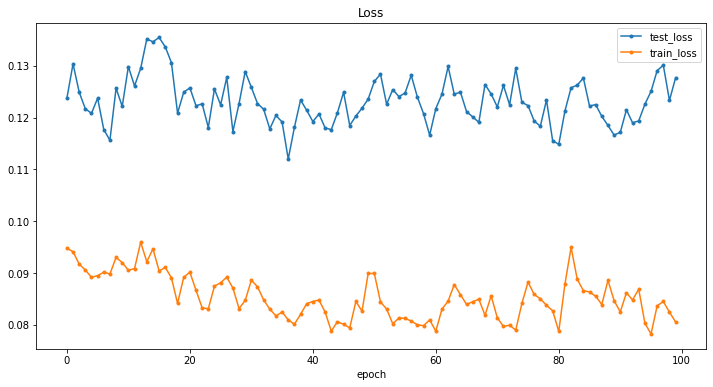

In [43]:
plt.figure(figsize=(12,6))
plt.title('Loss')
plt.xlabel('epoch')
plt.plot(model_results.test_loss, marker='.')
plt.plot(model_results.train_loss, marker='.')
plt.legend(['test_loss', 'train_loss']);

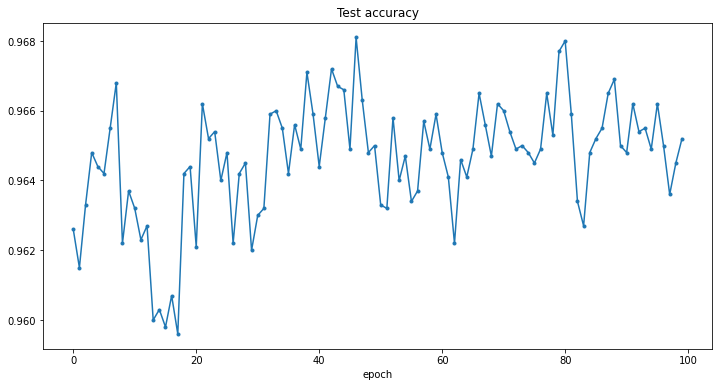

In [44]:
plt.figure(figsize=(12,6))
plt.title('Test accuracy')
plt.xlabel('epoch')
plt.plot(model_results.accuracy, marker='.');